# 6. Aumento da base de dados

Como observado no notebook 5, foi observado que o balanceamento das classes se provou muito importante na melhoria do acerto das classes de discos danificados. Contudo, apesar da melhoria, a dimuição considerável de discos sem danos nas etapas de treinamento e teste provocou um impacto substancial na precisão da classificação. Diante disso, será feita uma expansão das bases amostrais de treinamento e testes das classes de discos danificados por quebra ou dano por arco elétrico.

Assim, serão geradas novas imagens a partir daquelas presentes por meio de duas técnicas de filtragem que exedcutam o realce de bordas. As técnicas utilizadas são o **Filtro de Sobel** e o **Filtro de Laplaciano da Gaussiana**.

In [1]:
# Caminhos
caminho_base_treinamento = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados_Balanceados/Treinamento"
caminho_base_teste = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados_Balanceados/Teste"
rotulos_treinamento = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados_Balanceados/rotulos_regioes_treinamento.json"
rotulos_teste = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados_Balanceados/rotulos_regioes_teste.json"
rotulos_treinamento_finais = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados_Balanceados/rotulos_regioes_treinamento_finais.json"
rotulos_teste_finais = "/home/giovanni/Projetos/Local/TCC/Datasets/Recortes_Subamostrados_Balanceados/rotulos_regioes_teste_finais.json"

In [2]:
# Importação de bibliotecas
import os
import cv2
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Função para aplicar o filtro Sobel em uma imagem
def apply_sobel(image):
    # Verificar se a imagem foi carregada corretamente
    if image is None or image.size == 0:
        print("Erro: Não foi possível carregar a imagem")
        return None
    
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = cv2.magnitude(sobel_x, sobel_y)
        sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        return sobel
    except Exception as e:
        print("Erro ao aplicar o filtro Sobel:", e)
        return None

# Função para aplicar o filtro Laplaciano da Gaussiana em uma imagem
def apply_laplacian_of_gaussian(image):
    # Verificar se a imagem foi carregada corretamente
    if image is None or image.size == 0:
        print("Erro: Não foi possível carregar a imagem")
        return None
    
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
        laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        return laplacian
    except Exception as e:
        print("Erro ao aplicar o filtro Sobel:", e)
        return None

## 6.1. Ampliação do conjunto de treinamento

In [4]:
# Carregamento dos arquivos de rotulação
with open(rotulos_treinamento, "r") as f:
    rotulos = json.load(f)

# Lista para armazenamento de rotulos
rotulos_treinamento_atualizados = []

In [5]:
# Loop sobre as imagens e rótulos
for item in tqdm(rotulos, desc="Processando imagens"):
    nome_imagem = item["nome"]
    classificacao = item["classificacao"]
    caminho_imagem = os.path.join(caminho_base_treinamento, nome_imagem)
    imagem = cv2.imread(caminho_imagem)
    
    # Verificar se a imagem precisa de geração de novas imagens
    if classificacao in ["Broken", "Flashover damage"]:
        rotulos_treinamento_atualizados.append(item)
        
        # Sobel
        imagem_sobel = apply_sobel(imagem)
        caminho_sobel = os.path.join(caminho_base_treinamento, f"Sobel_{nome_imagem}")
        cv2.imwrite(caminho_sobel, imagem_sobel)
        # Laplaciano da Gaussiana
        imagem_laplaciano = apply_laplacian_of_gaussian(imagem)
        caminho_laplaciano = os.path.join(caminho_base_treinamento, f"Laplacian_{nome_imagem}")
        cv2.imwrite(caminho_laplaciano, imagem_laplaciano)
        
        # Atualizar os rótulos para incluir as novas imagens
        item_sobel = {"nome": f"Sobel_{nome_imagem}", "classificacao": classificacao}
        item_laplaciano = {"nome": f"Laplacian_{nome_imagem}", "classificacao": classificacao}
        rotulos_treinamento_atualizados.append(item_sobel)
        rotulos_treinamento_atualizados.append(item_laplaciano)
        
    else:
        # Se a imagem não precisar de processamento, apenas adicionamos o rótulo original
        rotulos_treinamento_atualizados.append(item)

Processando imagens: 100%|██████████████| 13759/13759 [00:03<00:00, 4246.24it/s]


In [6]:
# Salvar os rótulos atualizados em um novo arquivo
with open(rotulos_treinamento_finais, "w") as f:
    json.dump(rotulos_treinamento_atualizados, f, indent=4)

### 6.1.1. Visualização do balanceamento

In [7]:
# Lista para armazenar as classificações
classificacoes_treinamento = []

# Contagem das classificações
with open(rotulos_treinamento_finais, "r") as f:
    rotulos = json.load(f)
    for item in rotulos:
        classificacao = item["classificacao"]
        classificacoes_treinamento.append(classificacao)

# Contagem das ocorrências de cada classificação
contagem_no_issues = classificacoes_treinamento.count("No issues")
contagem_broken = classificacoes_treinamento.count("Broken")
contagem_flashover_damage = classificacoes_treinamento.count("Flashover damage")

In [8]:
# Lista com os valores das contagens
contagens_treinamento = [contagem_no_issues, contagem_broken, contagem_flashover_damage]

In [9]:
contagens_treinamento

[10783, 2808, 6120]

In [10]:
# Lista de rótulos para as fatias do gráfico de pizza
categorias = ["No issues", "Broken", "Flashover damage"]

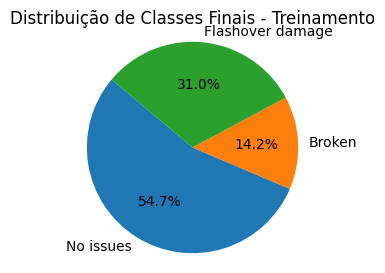

In [11]:
# Plotagem do gráfico de pizza
plt.figure(figsize=(3, 3))
plt.pie(contagens_treinamento, labels=categorias, autopct="%1.1f%%", startangle=140)
plt.title("Distribuição de Classes Finais - Treinamento")
plt.axis("equal")  # Garante que o gráfico seja desenhado como um círculo
plt.show()

## 6.2. Ampliação do conjunto de teste

In [12]:
# Carregamento dos arquivos de rotulação
with open(rotulos_teste, "r") as f:
    rotulos = json.load(f)

# Lista para armazenamento de rotulos
rotulos_teste_atualizados = []

In [14]:
# Loop sobre as imagens e rótulos
for item in tqdm(rotulos, desc="Processando imagens"):
    nome_imagem = item["nome"]
    classificacao = item["classificacao"]
    caminho_imagem = os.path.join(caminho_base_teste, nome_imagem)
    imagem = cv2.imread(caminho_imagem)
    
    # Verificar se a imagem precisa de geração de novas imagens
    if classificacao in ["Broken", "Flashover damage"]:
        rotulos_teste_atualizados.append(item)
        # Sobel
        imagem_sobel = apply_sobel(imagem)
        caminho_sobel = os.path.join(caminho_base_teste, f"Sobel_{nome_imagem}")
        cv2.imwrite(caminho_sobel, imagem_sobel)
        # Laplaciano da Gaussiana
        imagem_laplaciano = apply_laplacian_of_gaussian(imagem)
        caminho_laplaciano = os.path.join(caminho_base_teste, f"Laplacian_{nome_imagem}")
        cv2.imwrite(caminho_laplaciano, imagem_laplaciano)
        
        # Atualizar os rótulos para incluir as novas imagens
        item_sobel = {"nome": f"Sobel_{nome_imagem}", "classificacao": classificacao}
        item_laplaciano = {"nome": f"Laplacian_{nome_imagem}", "classificacao": classificacao}
        rotulos_teste_atualizados.append(item_sobel)
        rotulos_teste_atualizados.append(item_laplaciano)
        
    else:
        # Se a imagem não precisar de processamento, apenas adicionamos o rótulo original
        rotulos_teste_atualizados.append(item)

Processando imagens: 100%|████████████████| 3297/3297 [00:00<00:00, 4174.14it/s]


In [15]:
# Salvar os rótulos atualizados em um novo arquivo
with open(rotulos_teste_finais, "w") as f:
    json.dump(rotulos_teste_atualizados, f, indent=4)

### 6.2.1. Visualização do balanceamento

In [16]:
# Lista para armazenar as classificações
classificacoes_teste = []

# Contagem das classificações
with open(rotulos_teste_finais, "r") as f:
    rotulos = json.load(f)
    for item in rotulos:
        classificacao = item["classificacao"]
        classificacoes_teste.append(classificacao)

# Contagem das ocorrências de cada classificação
contagem_no_issues = classificacoes_teste.count("No issues")
contagem_broken = classificacoes_teste.count("Broken")
contagem_flashover_damage = classificacoes_teste.count("Flashover damage")

In [17]:
# Lista com os valores das contagens
contagens_teste = [contagem_no_issues, contagem_broken, contagem_flashover_damage]

In [22]:
contagens_teste

[2545, 717, 1539]

In [18]:
# Lista de rótulos para as fatias do gráfico de pizza
categorias = ["No issues", "Broken", "Flashover damage"]

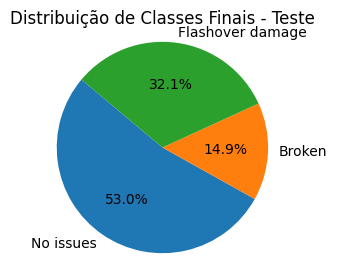

In [21]:
# Plotagem do gráfico de pizza
plt.figure(figsize=(3, 3))
plt.pie(contagens_teste, labels=categorias, autopct="%1.1f%%", startangle=140)
plt.title("Distribuição de Classes Finais - Teste")
plt.axis("equal")  # Garante que o gráfico seja desenhado como um círculo
plt.show()